## This notebook will construct the nodes and edges that we will build our graph with

In this notebook we use peaks that have been extracted from the spectra to construct a graph. Each node in the graph will be a peak, with attributes such as width of that peak, its Status, etc. . Edges between two peaks will exist based on two conditions. The first condition is that every peak, within a sample, will be connected to each other. The second condition is based on matching grid-slots. This means we will parse our spectra into grid squares and if two peaks are present in the same grid square, a relationjship will exist between them.

These relationships will be weighted by distance. That means we treat each peak as a point in a co-ordinate plane and calculate the euclidean distance between them. As the peaks in the same grid-slots will inherently be closer to each other than the peaks in the same sample, we will separately minmax scale these distances, so as not to give prefernece to one type of relationship. As well as this, in a graph, a larger weight is meant to represent a stronger connection between nodes. In order to account for this, we will get the inverse of our scaled distance to used as the relationship weight as we want peaks that are closer together to have a stronger connection.

Import relevant libraries and import raw data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

In [3]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

In [4]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")

Here we use scipy's function "find_peaks" to find all peaks in each individual spectra sample as well as pulling featurse such as prominence and width of peaks

In [5]:
peaks = []
widths = []
prom = []

for _, group in df.groupby('SpecID'):
    peak_index, weights = find_peaks(x=group['Absorbance'], prominence=75, width=6)
    peaks += list(group.iloc[peak_index].index.values)
    widths += list(weights['widths'])
    prom += list(weights['prominences'])

In [6]:
print(len(peaks))

35022


Below shows a scatterplot of the coordinates of all the peaks we have found

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

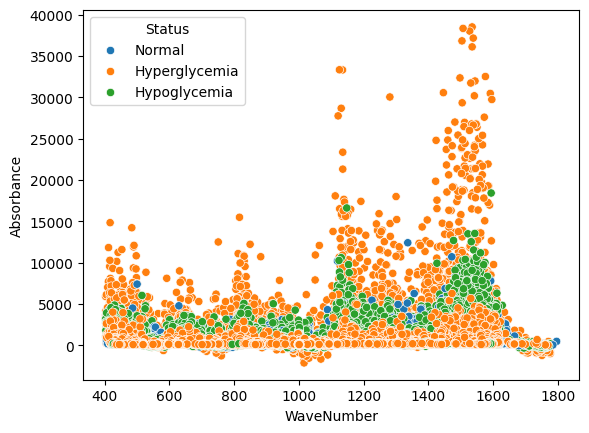

In [7]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", hue="Status")

We then add the peak information to our main dataframe

In [8]:
peak_df = df.iloc[peaks]
peak_df['Widths'] = widths
peak_df['Prominences'] = prom

/tmp/ipykernel_3675/2901317241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Widths'] = widths
/tmp/ipykernel_3675/2901317241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Prominences'] = prom


We then use the function to assign each peak we have found to a grid slot. We have speicified the slot sizes as they give a meaningful overlap to build our graph

In [9]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [10]:
# Set the size of the grid slots
WaveNumber_slot_size = 50
Absorbance_slot_size = 1000

peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)

/tmp/ipykernel_3675/3240670544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)


In [11]:
peak_df['GridSlot'].nunique()

343

In [12]:
peak_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,Widths,Prominences,GridSlot
316,201210-1-00,609,616.17310,201210-1,Normal,142.721697,57.085830,140.770239,"(12, 0)"
432,201210-1-00,725,695.44421,201210-1,Normal,163.729914,45.647206,172.675110,"(13, 0)"
734,201210-1-00,1027,901.82233,201210-1,Normal,111.162061,126.372452,137.963169,"(18, 0)"
880,201210-1-00,1173,1001.59450,201210-1,Normal,104.668998,78.989016,97.491288,"(20, 0)"
1524,201210-1-00,1817,1441.68570,201210-1,Normal,97.207776,58.388701,76.600582,"(28, 0)"


We will use "Node_ID" to find distances between peaks later on for our edge construction

In [13]:
peak_df['Node_ID'] = peak_df.index

/tmp/ipykernel_3675/412265839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Node_ID'] = peak_df.index


In [14]:
peak_df = peak_df.drop(columns=['Seq', 'SurID'])

Here we join the peak dataframe with itself in order to match peaks within the same Spectra Sample

In [15]:
same_sample = pd.merge(peak_df, peak_df[['SpecID', 'Node_ID']], on='SpecID', how='outer', suffixes=('_src', '_dst'))
same_sample['LINK:TYPE'] = 'SAMPLE'

In [16]:
same_sample.head()

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst,LINK:TYPE
0,201210-1-00,616.1731,Normal,142.721697,57.08583,140.770239,"(12, 0)",316,316,SAMPLE
1,201210-1-00,616.1731,Normal,142.721697,57.08583,140.770239,"(12, 0)",316,432,SAMPLE
2,201210-1-00,616.1731,Normal,142.721697,57.08583,140.770239,"(12, 0)",316,734,SAMPLE
3,201210-1-00,616.1731,Normal,142.721697,57.08583,140.770239,"(12, 0)",316,880,SAMPLE
4,201210-1-00,616.1731,Normal,142.721697,57.08583,140.770239,"(12, 0)",316,1524,SAMPLE


We then join the dataframe with itself again, this time to match peaks in the same grid slot

In [17]:
same_grid_slot = pd.merge(peak_df, peak_df[['GridSlot', 'Node_ID']], on='GridSlot', how='outer', suffixes=('_src', '_dst'))
same_grid_slot['LINK:TYPE'] = 'GRID'

In [18]:
same_grid_slot.head()

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst,LINK:TYPE
0,201210-1-00,616.1731,Normal,142.721697,57.08583,140.770239,"(12, 0)",316,316,GRID
1,201210-1-00,616.1731,Normal,142.721697,57.08583,140.770239,"(12, 0)",316,2373,GRID
2,201210-1-00,616.1731,Normal,142.721697,57.08583,140.770239,"(12, 0)",316,4405,GRID
3,201210-1-00,616.1731,Normal,142.721697,57.08583,140.770239,"(12, 0)",316,8515,GRID
4,201210-1-00,616.1731,Normal,142.721697,57.08583,140.770239,"(12, 0)",316,10562,GRID


We the combine these new dataframes together to form our relationship dataframe and we perform some clean to get rid of columns we don't need and renaming columns to get them ready for neo4j

In [19]:
graph_df = pd.concat([same_sample, same_grid_slot], ignore_index=True)

In [20]:
del same_sample
del same_grid_slot

In [21]:
graph_df = graph_df.drop(columns=['SpecID', 'GridSlot', 'WaveNumber', 'Absorbance', 'Status', 'Widths', 'Prominences'])

In [22]:
graph_df = graph_df.rename(columns={'Node_ID_src':':START_ID', 'Node_ID_dst':':END_ID'})

In [23]:
graph_df

,:START_ID,:END_ID,LINK:TYPE
0,316,316,SAMPLE
1,316,432,SAMPLE
2,316,734,SAMPLE
3,316,880,SAMPLE
4,316,1524,SAMPLE
...,...,...,...
33254523,964640,962591,GRID
33254524,964640,964640,GRID
33254525,963216,963216,GRID
33254526,968804,968804,GRID


This gets rid of relationships that match nodes to themselves

In [24]:
graph_df = graph_df[graph_df[':START_ID'] != graph_df[':END_ID']]

We make use of built in numpy functions to efficiently calculate distances between all of our relationships

In [25]:
wave = peak_df['WaveNumber']
absorb = peak_df['Absorbance']

src_indices = graph_df[':START_ID'].values
dst_indices = graph_df[':END_ID'].values

src_coords = np.column_stack((wave[src_indices], absorb[src_indices]))
dst_coords = np.column_stack((wave[dst_indices], absorb[dst_indices]))

distances = np.linalg.norm(src_coords - dst_coords, axis=1)

dist = distances.tolist()

In [26]:
graph_df['DIST'] = dist

/tmp/ipykernel_3675/3060805488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df['DIST'] = dist


In [27]:
graph_df.head()

,:START_ID,:END_ID,LINK:TYPE,DIST
1,316,432,SAMPLE,82.007646
2,316,734,SAMPLE,287.387358
3,316,880,SAMPLE,387.295318
4,316,1524,SAMPLE,826.766333
5,316,1781,SAMPLE,1001.870725


In [28]:
from sklearn.preprocessing import MinMaxScaler

sample_data = graph_df[graph_df['LINK:TYPE'] == 'SAMPLE']
grid_data = graph_df[graph_df['LINK:TYPE'] == 'GRID']

scaler = MinMaxScaler()

sample_data['DIST'] = 1 - scaler.fit_transform(sample_data[['DIST']])
grid_data['DIST'] = 1 -scaler.fit_transform(grid_data[['DIST']])

scaled_df = pd.concat([sample_data, grid_data])

/tmp/ipykernel_3675/945116818.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['DIST'] = 1 - scaler.fit_transform(sample_data[['DIST']])
/tmp/ipykernel_3675/945116818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_data['DIST'] = 1 -scaler.fit_transform(grid_data[['DIST']])


In [29]:
scaled_df.rename(columns={'DIST':'DIST:float'}, inplace=True)

In [30]:
scaled_df.head()

,:START_ID,:END_ID,LINK:TYPE,DIST:float
1,316,432,SAMPLE,0.998124
2,316,734,SAMPLE,0.993009
3,316,880,SAMPLE,0.990520
4,316,1524,SAMPLE,0.979575
5,316,1781,SAMPLE,0.975214


In [32]:
scaled_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

Finally, we clean and rename columsn in our main node dataframe to get it ready for neo4j

In [ ]:
peak_df

,SpecID,WaveNumber,Absorbance,Status,Widths,Prominences,GridSlot,Node_ID
613,201210-1-00,618.90662,1842.5710,Normal,57.732793,181.9741,"(12, 1)",613
727,201210-1-00,696.81091,1851.9185,Normal,33.525178,193.5749,"(13, 1)",727
1026,201210-1-00,901.13898,1746.4041,Normal,107.305604,157.9830,"(18, 1)",1026
1165,201210-1-00,996.12756,1702.7238,Normal,26.861586,115.9938,"(19, 1)",1165
1964,201210-1-00,1542.14120,1475.0056,Normal,15.749470,87.6968,"(30, 1)",1964
...,...,...,...,...,...,...,...,...
8008132,210526-3-49,450.79727,1482.5781,Hyperglycemia,11.954149,98.2019,"(9, 1)",8008132
8008234,210526-3-49,520.50116,1482.3167,Hyperglycemia,13.875621,86.4581,"(10, 1)",8008234
8008504,210526-3-49,705.01141,1507.8912,Hyperglycemia,54.718502,125.7380,"(14, 1)",8008504
8008936,210526-3-49,1000.22780,1505.2144,Hyperglycemia,18.241825,110.7786,"(20, 1)",8008936


In [ ]:
peak_df.rename(columns={"Status":"Status:LABEL"}, inplace=True)

In [ ]:
peak_df.rename(columns={'WaveNumber':'WaveNumber:float', 'Absorbance':'Absorbance:float', 'Widths':'Widths:float', 'Prominences':'Prominences:float', 'Node_ID':'Node_ID:ID'}, inplace=True)

In [ ]:
peak_df.to_csv(f'{neo4j_directory}/import/nodes.csv', index=False)

#### Creating Graph and Running Queries in Neo4j

In [ ]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [ ]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
Neo4j version: 5.12.0
Importing the contents of these files into C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\data\databases\neo4j:
Nodes:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv

Relationships:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv


Available resources:
  Total machine memory: 31.86GiB
  Free machine memory: 13.47GiB
  Max heap memory : 910.5MiB
  Max worker threads: 8
  Configured max memory: 11.43GiB
  High parallel IO: true

Cypher type normalization is enabled (disable with --normalize-types=false):
  Property type of 'WaveNumber' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv
  Property type of 'Absorbance' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\re

In [ ]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Error during restart:
Validating Neo4j configuration: C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\conf\neo4j.conf
5 issues found.

Validating user Log4j configuration: C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\conf\user-logs.xml
No issues found.

Validating server Log4j configuration: C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\conf\server-logs.xml
No issues found.

Neo4j service is not installed
Unable to start. See user log for details.
Run with '--verbose' for a more detailed error message.



Run and connect to the Neo4j Database

In [ ]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Passwords is defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [ ]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['Normal', 'Hyperglycemia', 'Hypoglycemia'],
      {
        SAMPLE: {
          orientation: 'UNDIRECTED',
          properties: 'DIST'
        },
        GRID: {
          orientation: 'UNDIRECTED',
          properties: 'DIST'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: Invalid relationship projection, one or more relationship types not found: 'SAMPLE|GRID'}

Define the graph algorithms.

In [ ]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [ ]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [ ]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [ ]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [ ]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [ ]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [ ]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [ ]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [ ]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'DIST',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [ ]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [ ]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'id', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'id', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'id', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'id', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'id', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'id', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['name', 'id', 'Louvain'])

In [ ]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['id', 'name'], how='left')

In [ ]:
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,id,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,210304-2-20,2554528,1.472942,346.263893,0.007547,0.232032,0,41093
1,210407-2-08,5289652,1.458982,684.913033,0.007900,0.301263,7,29932
2,210304-2-42,2612504,1.434791,341.089958,0.007298,0.230766,0,41093
3,210304-2-16,2543947,1.429760,290.571562,0.007041,0.219674,0,3169
4,210304-2-16,2543999,1.427356,290.504637,0.007031,0.219649,0,3169
...,...,...,...,...,...,...,...,...
51922,201210-1-22,57890,0.214485,25.412934,0.000221,0.155686,5,39855
51923,210114-1-38,361035,0.211477,9.794399,0.000170,0.152430,27,2445
51924,210114-2-34,484813,0.202604,32.973024,0.000282,0.157219,23,51517
51925,210414-3-34,5607088,0.202541,19.781042,0.000215,0.154603,7,22868


In [ ]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'id', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,210504-2-42,6475071,0.242307,0.138065,0.007172,0.028629,0.124967,0.089376,-0.046303,0.027830,...,-0.163882,-0.193443,0.059266,-0.040680,-0.167764,-0.398932,-0.223695,-0.009480,0.006383,-0.212466
1,210504-2-42,6475207,-0.096117,0.204142,-0.139659,-0.141973,-0.137281,0.280796,-0.053651,0.130047,...,-0.281887,-0.197054,-0.288132,0.074292,0.286876,0.250236,0.046473,0.269675,-0.029188,0.175356
2,210504-2-42,6475293,0.709152,-0.070849,0.119038,-0.304778,-0.020574,0.341190,0.325671,0.064778,...,0.056421,0.061122,-0.010972,0.093452,0.064267,0.223766,-0.036959,0.163036,0.203255,-0.297587
3,210504-2-42,6475365,0.711022,-0.070188,0.114619,-0.301435,-0.024669,0.345603,0.326444,0.065153,...,0.050077,0.063357,-0.009519,0.090731,0.073178,0.228672,-0.043176,0.166000,0.209547,-0.283292
4,210504-2-42,6475401,0.236866,0.108963,0.068784,-0.002663,-0.090655,-0.136845,-0.125278,-0.202254,...,0.146957,0.002154,0.095080,-0.042781,0.124655,-0.004160,0.003539,0.110795,0.023371,-0.157433


In [ ]:
status_df = pd.read_csv(f'{neo4j_directory}/import/nodes.csv')

In [ ]:
fastRP_df['id'] = fastRP_df['id'].astype(int)

In [ ]:
df['id'] = df['id'].astype(int)

In [ ]:
graph_df = pd.merge(df, status_df, left_on="id", right_on="Node_ID:ID", how="inner")
graph_df.drop(columns=["Node_ID:ID"], inplace=True)

In [ ]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="id", right_on="Node_ID:ID", how="inner")
fast_graph_df.drop(columns=["Node_ID:ID"], inplace=True)

In [ ]:
graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)
graph_df.drop(columns=['SpecID_y','Absorbance:float', 'Widths:float', 'Prominences:float', 'GridSlot'], inplace=True)
graph_df.rename(columns={'SpecID_x':'SpecID'}, inplace=True)

In [ ]:
fast_graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [ ]:
fast_graph_df.drop(columns=['SpecID_y', 'WaveNumber:float', 'Absorbance:float', 'Widths:float', 'Prominences:float', 'GridSlot'], inplace=True)
fast_graph_df.rename(columns={'SpecID_x':'SpecID'}, inplace=True)

In [ ]:
graph_df

,SpecID,id,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,WaveNumber:float,Status
0,210304-2-20,2554528,1.472942,346.263893,0.007547,0.232032,0,41093,1028.92940,Hypoglycemia
1,210407-2-08,5289652,1.458982,684.913033,0.007900,0.301263,7,29932,1024.82910,Normal
2,210304-2-42,2612504,1.434791,341.089958,0.007298,0.230766,0,41093,1033.02970,Hypoglycemia
3,210304-2-16,2543947,1.429760,290.571562,0.007041,0.219674,0,3169,1000.91110,Hypoglycemia
4,210304-2-16,2543999,1.427356,290.504637,0.007031,0.219649,0,3169,1036.44640,Hypoglycemia
...,...,...,...,...,...,...,...,...,...,...
51922,201210-1-22,57890,0.214485,25.412934,0.000221,0.155686,5,39855,1946.01370,Normal
51923,210114-1-38,361035,0.211477,9.794399,0.000170,0.152430,27,2445,227.33485,Normal
51924,210114-2-34,484813,0.202604,32.973024,0.000282,0.157219,23,51517,1982.23230,Normal
51925,210414-3-34,5607088,0.202541,19.781042,0.000215,0.154603,7,22868,1869.47610,Normal


In [ ]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
graph_df['Bin'] = graph_df['WaveNumber:float'].apply(lambda x: calculate_bin_interval(x, bin_size))

In [ ]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = graph_df.pivot_table(index='SpecID', columns='Bin', values=['PageRank', 'DegreeCentrality', 'EigenvectorCentrality', 'ArticleRank', 'Leiden', 'Louvain'], aggfunc='mean')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = graph_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(False, inplace=True)

C:\Users\stang\AppData\Local\Temp\ipykernel_19564\286844324.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  peak_bins.fillna(False, inplace=True)


In [ ]:
graph_bins = peak_bins.reset_index()

In [ ]:
peak_bins

,ArticleRank_1000-1025,ArticleRank_1025-1050,ArticleRank_1050-1075,ArticleRank_1075-1100,ArticleRank_1100-1125,ArticleRank_1125-1150,ArticleRank_1150-1175,ArticleRank_1175-1200,ArticleRank_1200-1225,ArticleRank_1225-1250,...,PageRank_775-800,PageRank_800-825,PageRank_825-850,PageRank_850-875,PageRank_875-900,PageRank_900-925,PageRank_925-950,PageRank_950-975,PageRank_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,0.687047,False,False,0.922911,Normal
201210-1-01,False,False,False,False,False,0.281905,False,False,False,0.298914,...,False,False,False,False,0.819122,False,False,False,0.830504,Normal
201210-1-02,0.348318,False,False,False,False,0.274968,False,False,False,False,...,False,False,False,False,False,0.68636,False,False,False,Normal
201210-1-03,False,False,0.235851,False,False,False,0.213873,False,False,0.299763,...,False,False,False,False,False,0.755825,False,False,0.845046,Normal
201210-1-04,0.342233,False,False,False,False,False,False,0.263323,False,False,...,False,False,False,False,False,False,False,False,False,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,0.358607,False,False,False,0.294853,False,False,False,False,False,...,False,False,False,1.055476,False,False,False,False,False,Hyperglycemia
210526-3-46,0.365934,False,False,False,False,0.298666,False,False,False,False,...,False,False,False,1.082378,False,False,False,False,False,Hyperglycemia
210526-3-47,0.370506,False,False,False,0.301694,False,False,False,False,False,...,False,False,False,False,False,0.755558,False,False,False,Hyperglycemia


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = peak_bins.drop(['Status'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.7630 +/- 0.0171
ExtraTreesClassifier Cross-Validation Accuracy: 0.7654 +/- 0.0185


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

In [ ]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [ ]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [ ]:
calculate_metrics(y_test, rf_predictions)

Overall Accuracy: 0.7533557046979866


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.77      0.74      0.76       195
 Hypoglycemia       0.72      0.77      0.74       196
       Normal       0.77      0.75      0.76       205

     accuracy                           0.75       596
    macro avg       0.75      0.75      0.75       596
 weighted avg       0.75      0.75      0.75       596


Confusion Matrix:
[[145  27  23]
 [ 23 150  23]
 [ 21  30 154]]


In [ ]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.7533557046979866


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.78      0.74      0.76       195
 Hypoglycemia       0.72      0.79      0.75       196
       Normal       0.77      0.73      0.75       205

     accuracy                           0.75       596
    macro avg       0.75      0.75      0.75       596
 weighted avg       0.75      0.75      0.75       596


Confusion Matrix:
[[145  25  25]
 [ 21 154  21]
 [ 20  35 150]]


In [ ]:
get_feature_importances(rf_model, X)

,Feature,Importance
114,DegreeCentrality_250-275,0.010965
0,ArticleRank_1000-1025,0.010885
72,DegreeCentrality_1000-1025,0.009952
216,Leiden_1000-1025,0.009915
402,PageRank_250-275,0.009564
309,Louvain_1525-1550,0.009120
186,EigenvectorCentrality_250-275,0.008838
360,PageRank_1000-1025,0.008253
144,EigenvectorCentrality_1000-1025,0.008224
42,ArticleRank_250-275,0.008186


In [ ]:
get_feature_importances(et_model, X)

,Feature,Importance
216,Leiden_1000-1025,0.011804
402,PageRank_250-275,0.007462
360,PageRank_1000-1025,0.007424
412,PageRank_500-525,0.007404
186,EigenvectorCentrality_250-275,0.007185
42,ArticleRank_250-275,0.007055
72,DegreeCentrality_1000-1025,0.006910
309,Louvain_1525-1550,0.006650
0,ArticleRank_1000-1025,0.006526
144,EigenvectorCentrality_1000-1025,0.006481


## FastRp

In [ ]:
fast_graph_df.drop(columns=['id'], inplace=True)
fast_graph_df = fast_graph_df.groupby(['SpecID', 'Status']).max().reset_index()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y = fast_graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y = fast_graph_df['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.7080536912751678
Extra Trees Accuracy: 0.7365771812080537


Fast rp mixed with traditional graph metrics

In [ ]:
joined_graph = pd.merge(graph_bins, fast_graph_df, on=['SpecID', 'Status'], how='inner')

In [ ]:
joined_graph

,SpecID,ArticleRank_1000-1025,ArticleRank_1025-1050,ArticleRank_1050-1075,ArticleRank_1075-1100,ArticleRank_1100-1125,ArticleRank_1125-1150,ArticleRank_1150-1175,ArticleRank_1175-1200,ArticleRank_1200-1225,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,False,False,False,False,False,False,False,False,False,...,0.335095,0.106210,0.218794,0.374632,0.103860,0.245072,0.373493,0.229880,0.075875,0.181444
1,201210-1-01,False,False,False,False,False,0.281905,False,False,False,...,0.312469,0.233535,0.399692,0.384493,0.337853,0.290994,0.378513,0.265408,0.353757,0.268856
2,201210-1-02,0.348318,False,False,False,False,0.274968,False,False,False,...,0.449765,0.201674,0.326597,0.195319,0.246575,0.304056,0.146214,0.133391,0.286643,0.329961
3,201210-1-03,False,False,0.235851,False,False,False,0.213873,False,False,...,0.281217,0.115728,0.203613,0.283782,0.257662,0.256586,0.368587,0.254083,0.284300,0.319423
4,201210-1-04,0.342233,False,False,False,False,False,False,0.263323,False,...,0.278503,0.154629,0.069401,0.201625,0.246042,0.266603,0.139671,0.104696,0.256033,0.326068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974,210526-3-45,0.358607,False,False,False,0.294853,False,False,False,False,...,0.258776,0.141139,0.245855,0.059278,0.310732,0.237065,0.471860,0.307975,0.467477,0.181135
2975,210526-3-46,0.365934,False,False,False,False,0.298666,False,False,False,...,0.258800,0.056721,0.474081,0.056735,0.391064,0.235629,0.057258,0.304588,0.091715,0.180317
2976,210526-3-47,0.370506,False,False,False,0.301694,False,False,False,False,...,0.351544,0.150387,0.476191,0.287117,0.391562,0.235737,0.020326,0.303201,0.307041,0.059249
2977,210526-3-48,0.374132,False,False,False,False,0.302655,False,False,False,...,0.339747,0.149548,0.475432,0.081453,0.390361,0.232553,0.060482,0.303456,0.085901,0.179476


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = joined_graph.drop(columns=['SpecID', 'Status'])

# Target variable
y = joined_graph['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.7449664429530202
Extra Trees Accuracy: 0.7651006711409396


Delete the projection

In [ ]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

C:\Users\stang\AppData\Local\Temp\ipykernel_19564\2107130262.py:8: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.drop`: Caused by: java.util.NoSuchElementException: Graph with name `myGraph` does not exist on database `neo4j`. It might exist on another database.}

In [ ]:
close_driver()